# 模組 1.3: 系統化探索性資料分析 (EDA) 實戰

## 學習目標
- 整合 Pandas 和 Seaborn/Matplotlib 技能進行綜合分析
- 學習遵循一個結構化的 EDA 工作流程
- 練習從視覺化和統計中提出初步假設
- 對真實資料集進行端到端的初步探索，並總結發現

## 導論：執行系統化 EDA

在您的指南《駕馭未知》中，系統化的工作流程被強調為成功的關鍵。本筆記本將嚴格遵循該指南中 **階段二（初步資料理解與結構化）** 和 **階段三（生成初步假設）** 的策略，將前兩個筆記本學到的技能應用於鐵達尼號資料集。

我們將遵循以下步驟：
1.  **定義問題**: 我們想了解哪些因素與乘客的生還有關？
2.  **載入與檢視資料**: 進行基本品質掃描。
3.  **單變數分析**: 探索每個特徵自身的分佈與特性。
4.  **雙變數與多變數分析**: 探索特徵之間，特別是與目標變數 `Survived` 之間的關係。
5.  **生成假設與總結**: 根據分析提出初步假設，並總結我們的發現。

In [14]:
# 導入必要的函式庫
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 設定視覺化風格
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
print("Libraries and styles configured.")

# 忽略不必要的警告訊息
import warnings
warnings.filterwarnings('ignore')



Libraries and styles configured.


## 1. 定義問題與載入資料

In [15]:
# 我們分析的核心問題是：鐵達尼號乘客的生還狀況(`Survived`)與哪些特徵有關？
# 這是一個典型的二元分類問題的探索階段。

# 載入資料
path = r'..\..\..\..\datasets\raw\titanic\train.csv'
df = pd.DataFrame()
try:
    df = pd.read_csv(path)
    print("成功載入 Titanic 資料集!")
    print(f"資料集維度: {df.shape}")
except FileNotFoundError:
    print(f"在 '{path}' 找不到 train.csv。")



成功載入 Titanic 資料集!
資料集維度: (891, 12)


## 2. 初步資料品質掃描

讓我們快速回顧一下資料的基本情況。

In [16]:
# 使用 .info() 檢查資料類型和缺失值
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


**初步發現**:
- **PassengerId, Survived, Pclass, SibSp, Parch** 是整數型。
- **Name, Sex, Ticket, Cabin, Embarked** 是物件型（字串）。
- **Age, Fare** 是浮點數型。
- **缺失值**: `Age` (891-714=177個缺失), `Cabin` (891-204=687個缺失), `Embarked` (2個缺失)。`Cabin` 的缺失情況非常嚴重。

## 3. 單變數分析 (Univariate Analysis)

我們將逐一檢視主要特徵的分佈。

### 目標變數: `Survived`

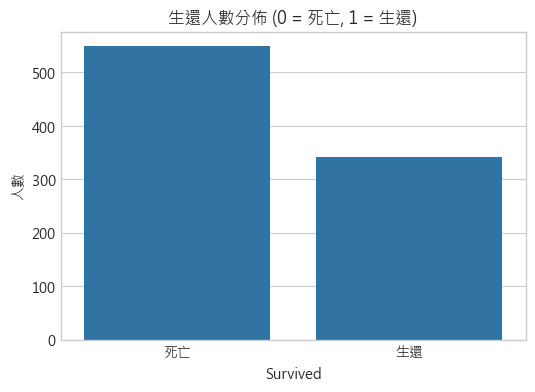

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


In [17]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Survived', data=df)
plt.title('生還人數分佈 (0 = 死亡, 1 = 生還)')
plt.xticks([0, 1], ['死亡', '生還'])
plt.ylabel('人數')
plt.show()

print(df['Survived'].value_counts(normalize=True))



約 61.6% 的乘客不幸遇難，生還率約為 38.4%。

### 其他主要特徵: `Pclass`, `Sex`, `Embarked`

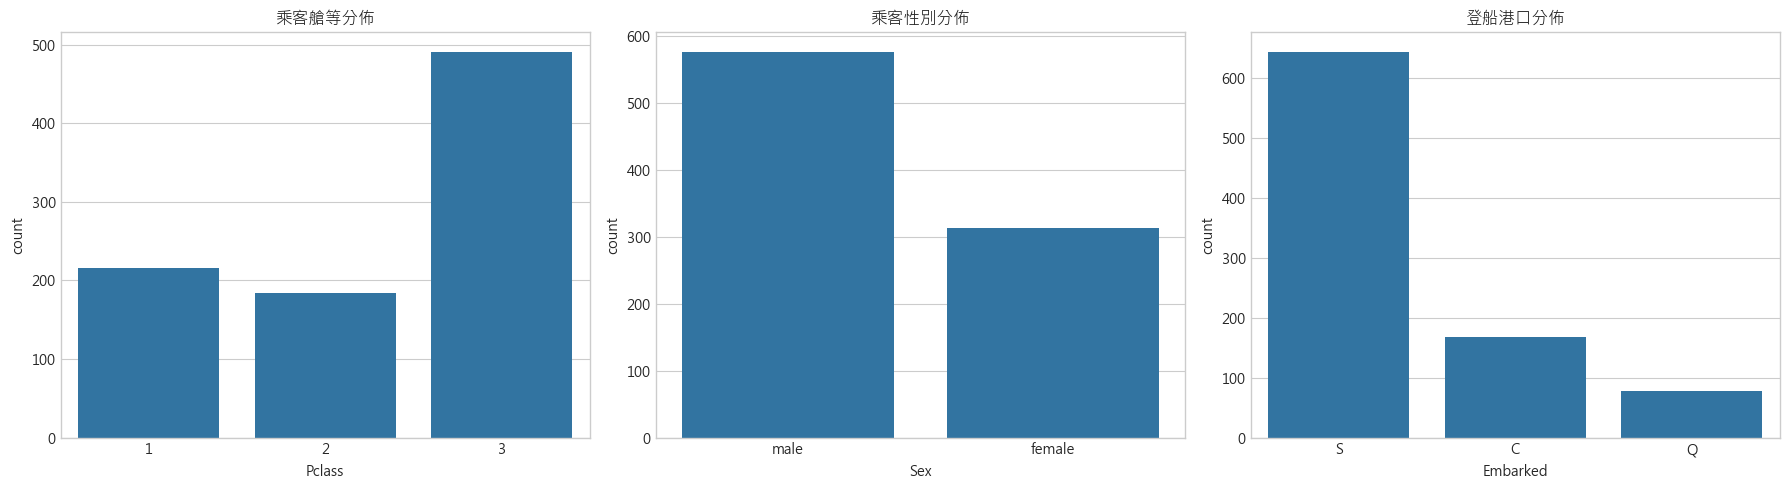

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.countplot(x='Pclass', data=df, ax=axes[0]).set_title('乘客艙等分佈')
sns.countplot(x='Sex', data=df, ax=axes[1]).set_title('乘客性別分佈')
sns.countplot(x='Embarked', data=df, ax=axes[2]).set_title('登船港口分佈')

plt.tight_layout()
plt.show()



**發現**:
- 乘客以三等艙居多。
- 男性乘客數量遠多於女性。
- 大部分乘客從 S 港口登船。

### 數值特徵: `Age` 和 `Fare`

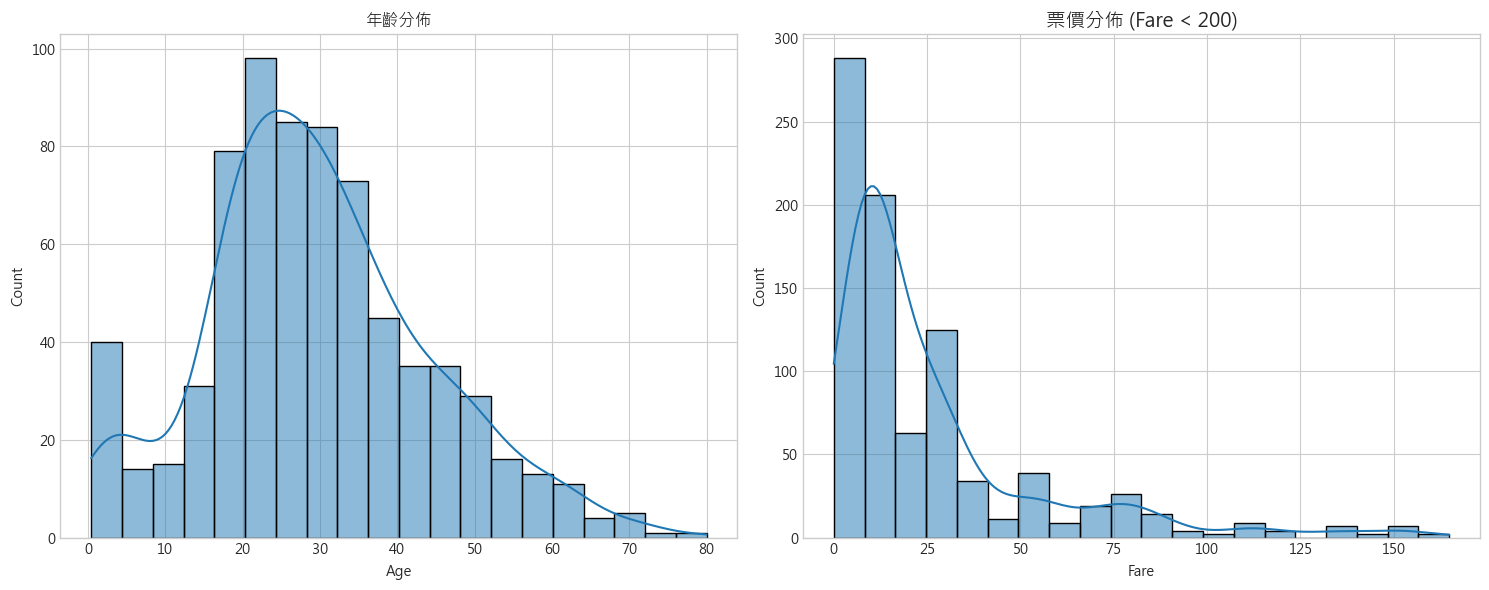

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(df['Age'].dropna(), kde=True, ax=axes[0], bins=20).set_title('年齡分佈')
sns.histplot(df[df['Fare'] < 200]['Fare'], kde=True, ax=axes[1], bins=20).set_title('票價分佈 (Fare < 200)', fontsize=14) # 過濾掉極端異常值以利觀察

plt.tight_layout()
plt.show()


**發現**:
- 年齡呈現多峰分佈，有一個嬰兒潮，主要乘客集中在青壯年。
- 票價是高度右偏的，大部分乘客支付了較低的票價。

## 4. 雙變數與多變數分析

這是 EDA 的核心，我們將探索特徵與 `Survived` 之間的關係。

### `Pclass` vs. `Survived`

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


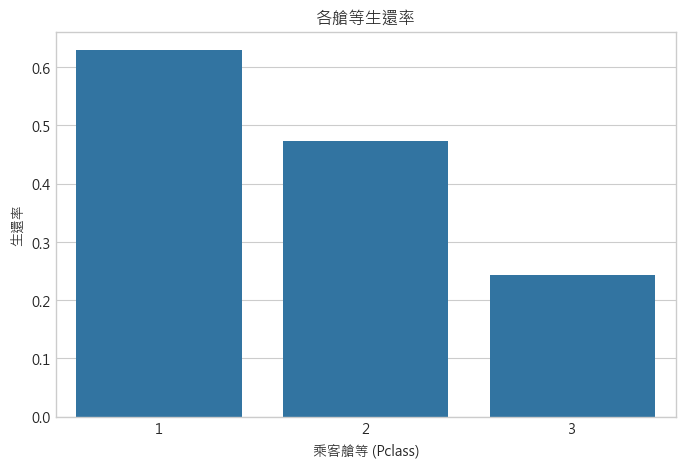

In [20]:
# 使用 groupby 計算不同艙等的生還率
pclass_survival = df.groupby('Pclass')['Survived'].mean()
print(pclass_survival)

plt.figure(figsize=(8, 5))
sns.barplot(x=pclass_survival.index, y=pclass_survival.values)
plt.title('各艙等生還率')
plt.ylabel('生還率')
plt.xlabel('乘客艙等 (Pclass)')
plt.show()



**假設 1**: 乘客的社會經濟地位（由 Pclass 反映）是影響生還率的關鍵因素。艙等越高，生還率越高。

### `Sex` vs. `Survived`

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


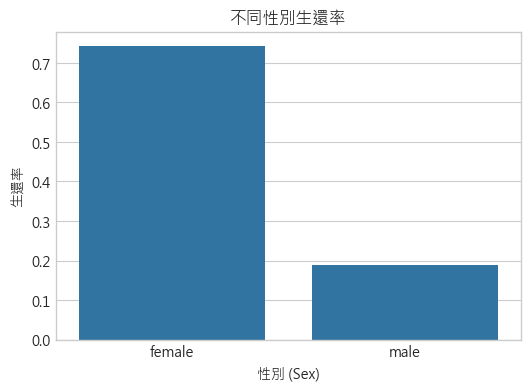

In [21]:
sex_survival = df.groupby('Sex')['Survived'].mean()
print(sex_survival)

plt.figure(figsize=(6, 4))
sns.barplot(x=sex_survival.index, y=sex_survival.values)
plt.title('不同性別生還率')
plt.ylabel('生還率')
plt.xlabel('性別 (Sex)')
plt.show()



**假設 2**: 女性的生還率遠高於男性，這符合「婦女和兒童優先」的原則。

### `Age` vs. `Survived`

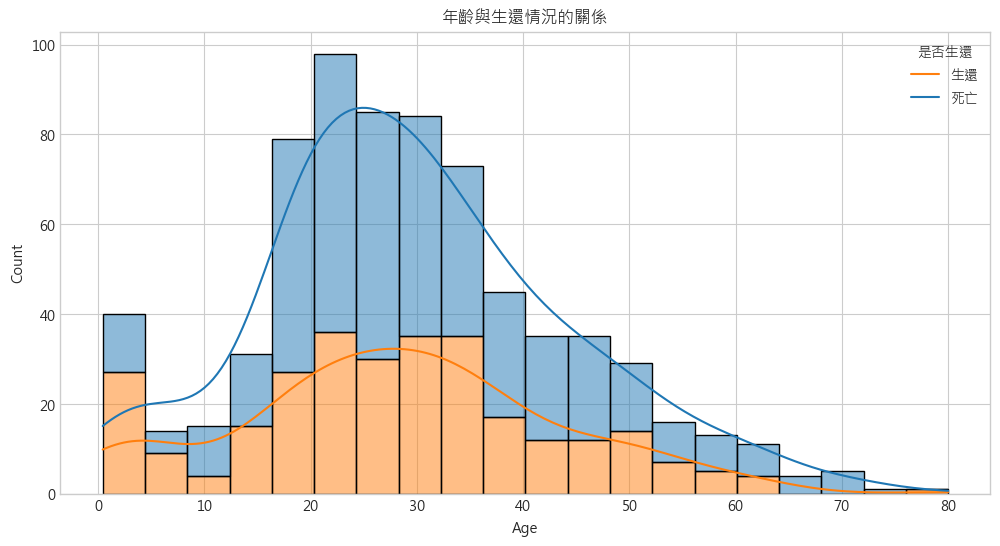

In [22]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Age', hue='Survived', kde=True, multiple="stack")
plt.title('年齡與生還情況的關係')
plt.legend(title='是否生還', labels=['生還', '死亡'])
plt.show()



**假設 3**: 兒童（特別是 10 歲以下）的生還率較高。老年人的生還率較低。

### 結合多變數

讓我們看看 `Pclass` 和 `Sex` 對 `Survived` 的綜合影響。

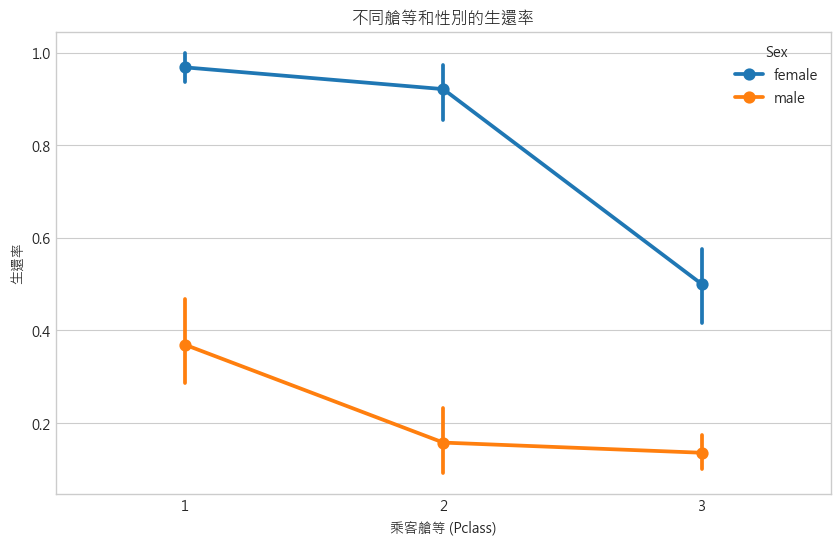

In [23]:
plt.figure(figsize=(10, 6))
sns.pointplot(x='Pclass', y='Survived', hue='Sex', data=df)
plt.title('不同艙等和性別的生還率')
plt.ylabel('生還率')
plt.xlabel('乘客艙等 (Pclass)')
plt.show()



**強化發現**:
- 在所有艙等中，女性的生還率都遠高於男性。
- 即使是三等艙的女性，其生還率也高於一等艙的男性。這表明性別是一個比艙等等級更強的預測因子。

### 數值特徵的相關性

最後，我們用熱力圖來看看數值特徵之間的線性相關性。

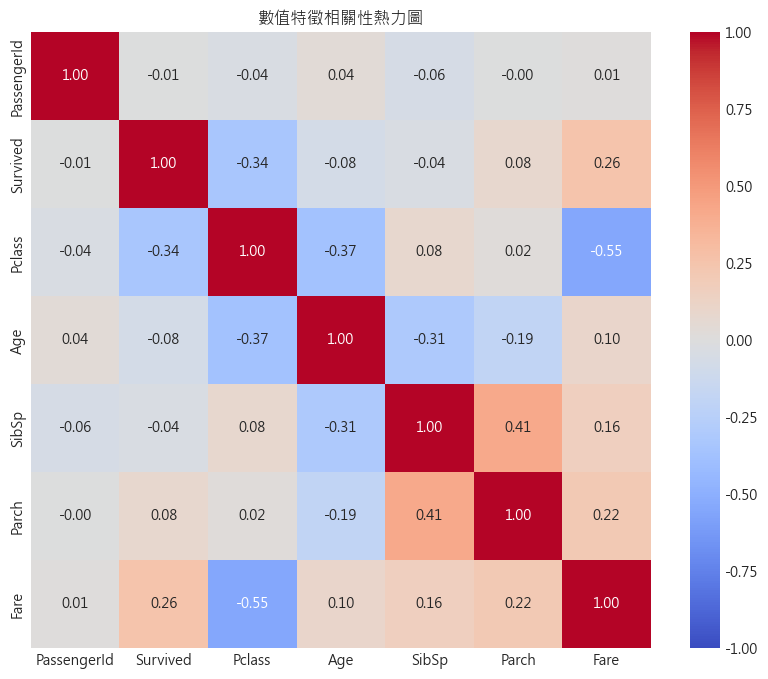

In [36]:
# 選取數值型欄位
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('數值特徵相關性熱力圖')
plt.show()



**發現**:
- `Survived` 與 `Pclass` 呈負相關（-0.34），意味著艙等等級數字越小（艙等越高），生還率越高，這驗證了我們的發現。
- `Survived` 與 `Fare` 呈正相關（0.26），票價越高，生還率越高，這與 Pclass 的結論一致。
- `Pclass` 和 `Fare` 之間有很強的負相關（-0.55），符合預期。
- `SibSp` (兄弟姊妹/配偶數) 和 `Parch` (父母/子女人數) 之間有中等程度的正相關。

## 5. 初步總結與假設

經過這輪系統化的 EDA，我們從一個未知的資料集中獲得了以下關鍵洞見，並生成了初步假設：

- **最重要的生還預測因子**:
  1.  **性別 (Sex)**: 女性的生還優先級遠高於男性。
  2.  **社會階級 (Pclass)**: 艙等越高，生還的可能性越大。

- **次要的生還預測因子**:
  1.  **年齡 (Age)**: 兒童的生還率較高。
  2.  **家庭大小 (SibSp, Parch)**: (此部分未深入，但相關圖可顯示出中等家庭大小的人存活率較高)
  3.  **登船港口 (Embarked)**: (可能與社會階級有關，C 港口登船的乘客生還率較高)

- **待處理問題**:
  - **缺失值**: `Age`, `Cabin`, `Embarked` 需要在特徵工程階段被妥善處理。
  - **特徵創建**: `Name` 中的稱謂（Mr., Mrs., Miss）可能包含年齡和社會地位信息。`SibSp` 和 `Parch` 可以合併為 `FamilySize`。

這次 EDA 為我們接下來的資料清理和特徵工程指明了清晰的方向。